# Spectral wave attenuation for the spring deployment
In this notebook, we derive frequency dependent wave attenuation using data from the spring deployment. We will only use the second part of the deployment, where SWIFT20 was in open water. And the wave activity generally was high enough to measure (significant wave height \> 0.1 m) at the location of SWIFT21. We derive the attenuation assuming an exponential decay. For each pair of data points, the attenuation coefficient $\alpha$ is computed with
$$
\alpha(f) = \frac{\ln(E_\text{SWIFT20}(f) - E_\text{SWIFT21}(f)}{d}
$$
where $f$ is the frequency, $E$ the power spectral density and $d$ is the distance from the ice edge to SWIFT21 in the direction of swell waves as measured by SWIFT21.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

import waves
import attenuation as at
 
rc('font', size = 14)
plt.rcParams['mathtext.fontset'] = "stix" # Nicer latex labels

In [2]:
swift20_file = "../processed_data/swift20_spring.feather"
swift21_file = "../processed_data/swift21_spring.feather"

frequency_range = [0.05, 0.13] # Hz
swh_threshold = 0.1 # Minimum significant wave height (m)

### Get wave properties from both buoys:
We will remove data points where the significant wave height was too low (< 0.1 m) and select the desired time range.

In [3]:
swift20 = pd.read_feather(swift20_file)
swift21 = pd.read_feather(swift21_file)

In [4]:
tmin = pd.Timestamp('2019-10-31T23:30')
tmax = min(swift20.timestamp[len(swift20)-1], swift21.timestamp[len(swift21)-1])

swift20_pruned = swift20[(swift20.timestamp >= tmin) & (swift20.timestamp <= tmax)].reset_index()
swift21_pruned = swift21[(swift21.timestamp >= tmin) & (swift21.timestamp <= tmax)].reset_index()

# 3 data points are missing from swift21. The following one-line hack will introduce NaN rows there, so
# that swift20_pruned and swift21_pruned have matching rows 
swift21_pruned = swift21_pruned.set_index('timestamp').reindex(swift20_pruned.timestamp.values).reset_index()

# Remove data with no measureable wave activity
ok_swh = (swift20_pruned.sigwaveheight > swh_threshold) & (swift21_pruned.sigwaveheight > swh_threshold)

# Remove outliers (one wave direction outlier that result in a very large distance to edge)
distance_threshold = 2.5e5 #m
ok_dist = (swift20_pruned.dist_wavedir < distance_threshold) & (swift21_pruned.dist_wavedir < distance_threshold)

swift20_pruned = swift20_pruned[ok_swh & ok_dist].reset_index()
swift21_pruned = swift21_pruned[ok_swh & ok_dist].reset_index()   

print(f"Used time range: {tmin} - {tmax}")

Used time range: 2019-10-31 23:30:00 - 2019-11-07 10:00:00


### Compute pointwise attenuation

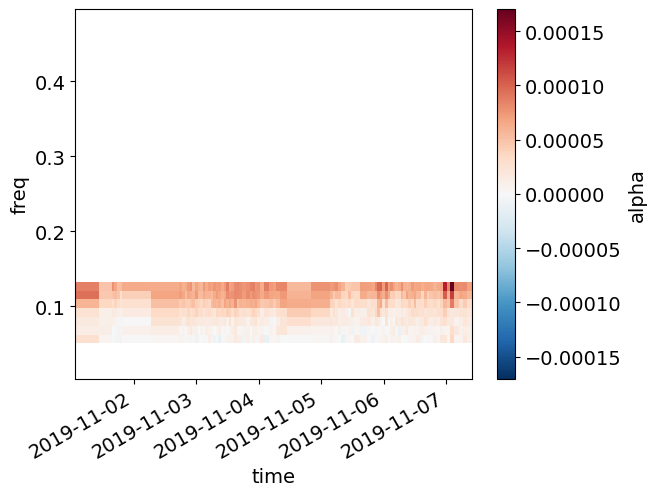

In [5]:
distance = swift21_pruned['dist_wavedir']
swift20_spectra = waves.get_wavespectra(swift20_pruned)
swift21_spectra = waves.get_wavespectra(swift21_pruned)

ds = at.get_pointwise_attenuation(swift21_spectra, swift20_spectra, frequency_range, distance)
ds.alpha.plot()

### Fit to power law
We now fit the pointwise attenuation to a power law
$$
\alpha(f) = a \cdot f^b
$$

In [6]:
# Initial parameter guess
a0 = 1
b0 = 3

fits = {'general':     {'options': {},
                        'plot_kwargs': {'label': r'$af^b$'}},
        'cubic':       {'options': {'b': 3},
                        'plot_kwargs': {'label': r'$af^3$',
                                        'linestyle': 'dashed'}},
        'linear':      {'options': {'b':1},
                        'plot_kwargs': {'label': r'$af$',
                                        'linestyle': 'dotted',
                                        'color': 'black'}}
       }

# Fit to power law
for key in fits.keys():
    (a,b,rmse) = at.fit_alpha(ds.alpha, a0, b0, **fits[key]['options'])
    fits[key]['a'] = a
    fits[key]['b'] = b
    fits[key]['rmse'] = rmse

# Print result  
for key in fits.keys():
    print(f"{key}:\t a = {fits[key]['a']:.5f} \t b = {fits[key]['b']:.5f} \t RMSE = {fits[key]['rmse']:.4e}")

general:	 a = 0.06285 	 b = 3.25317 	 RMSE = 1.2243e-05
cubic:	 a = 0.03635 	 b = 3.00000 	 RMSE = 1.2327e-05
linear:	 a = 0.00039 	 b = 1.00000 	 RMSE = 2.0186e-05


## Box-and-whisker plot

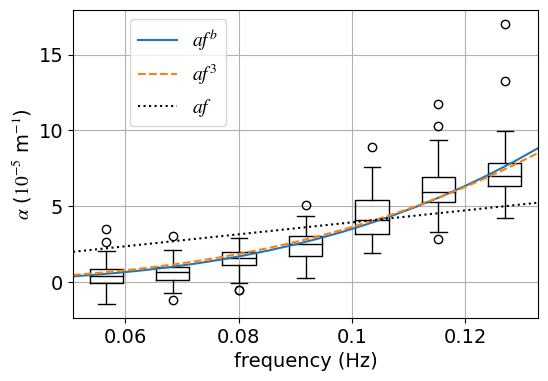

In [7]:
plt.figure(figsize=(6,4))
at.alpha_boxplot(ds.alpha)
for key in fits.keys():
    at.plot_fit(fits[key]['a'], fits[key]['b'], **fits[key]['plot_kwargs'])
plt.legend(bbox_to_anchor = (0.35,1))
plt.grid()
plt.savefig('../figures/spring_atteunation.png', dpi=300, bbox_inches='tight')

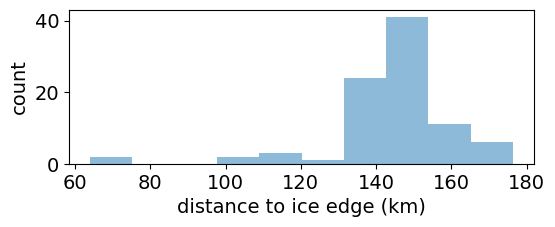

In [8]:
plt.figure(figsize=(6,2))
plt.hist(ds.distance.values*1e-3, alpha=0.5)
plt.xlabel('distance to ice edge (km)')
plt.ylabel('count')
plt.savefig('../figures/spring_atteunation_distance.png', dpi=300, bbox_inches='tight')